In [1]:
comments = 'resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y'
carbon_tax = 80
transport_CO2_tax = 150
## Parameterize lifetime and km driven yearly of EVs
#lifetime expressed in years 
#Mileage expessed in tkm/year
lifetime = 10
mileage = 15


In [2]:
from datetime import datetime
import time
import os

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
#from message_ix_models.util import broadcast, same_node
import message_ix
from ixmp.utils import maybe_check_out

import xlsxwriter
import openpyxl


from message_ix.reporting import Reporter
from ixmp.reporting import configure
#from message_ix_models import ScenarioInfo
from message_data.tools.post_processing.iamc_report_hackathon import report as reporting
from message_data.model.material.util import read_config

import message_data.tools.post_processing.iamc_report_hackathon
import importlib

from message_ix.utils import make_df
import ixmp
import message_data

from data_trade_glb import gen_trade_data
from data_mats_global import gen_mats_data
from gen_imports import gen_imports
from gen_exports import gen_exports

import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>

In [4]:
mp = ixmp.Platform()

2023-11-27 09:41:35,550  INFO at.ac.iiasa.ixmp.Platform:165 - Welcome to the IX modeling platform!
2023-11-27 09:41:35,553  INFO at.ac.iiasa.ixmp.Platform:166 -  connected to database 'jdbc:hsqldb:file:/home/lorenzou/.local/share/ixmp/localdb/default' (user: ixmp)...


## Set-up model

In [5]:
# Specify filename and name of sheet for data extraction
filename = '/home/lorenzou/eptex/indecol/USERS/Lorenzo/message_ix/inputs/input_LIBs.xlsx'
sheet_name = 'Graphite_format'
sheet_historical = 'Capacities'
#demand_sheet = 'demand'
imports_exports_sheet = 'import_exports'
trade_sheet = 'GLB_trade'

In [6]:
mp.scenario_list()

,model,scenario,scheme,is_default,is_locked,cre_user,cre_date,upd_user,upd_date,lock_user,lock_date,annotation,version
0,MaterialsTransport_Global,1xresources_100Li_80USD_EV240USD,MESSAGE,1,0,lorenzou,2023-11-22 18:16:36.832000,lorenzou,2023-11-22 18:58:38.579000,None,None,clone Scenario from 'MaterialsTransport_Global...,1
1,MaterialsTransport_Global,Baseline,MESSAGE,1,0,lorenzou,2023-10-23 10:36:04.535000,lorenzou,2023-10-23 11:01:54.100000,None,None,Import from MESSAGEix-GLOBIOM_1.1-MT_vehicles_...,1
2,MaterialsTransport_Global,no_cap_10xresources_100Li_80USD_EV150USD,MESSAGE,1,0,lorenzou,2023-11-21 10:08:11.248000,lorenzou,2023-11-21 11:15:34.496000,None,None,clone Scenario from 'MaterialsTransport_Global...,1
3,MaterialsTransport_Global,no_cap_10xresources_100Li_80USD_EV150USD_repor...,MESSAGE,1,0,lorenzou,2023-11-22 09:47:00.477000,lorenzou,2023-11-22 10:32:51.895000,None,None,clone Scenario from 'MaterialsTransport_Global...,1
4,MaterialsTransport_Global,no_cap_10xresources_10Li_80USD_EV240USD_report...,MESSAGE,1,0,lorenzou,2023-11-22 15:46:09.017000,lorenzou,2023-11-22 16:30:57.568000,None,None,clone Scenario from 'MaterialsTransport_Global...,1
5,MaterialsTransport_Global,resource_1xAgrades_100xBgrades_150USD_EV150USD...,MESSAGE,1,0,lorenzou,2023-11-24 14:46:53.534000,None,None,None,None,clone Scenario from 'MaterialsTransport_Global...,1
6,MaterialsTransport_Global,resource_1xAgrades_100xBgrades_150USD_EV150USD...,MESSAGE,1,0,lorenzou,2023-11-24 16:15:22.307000,None,None,None,None,clone Scenario from 'MaterialsTransport_Global...,1
7,MaterialsTransport_Global,resource_1xAgrades_100xBgrades_80USD_EV0USD_ch...,MESSAGE,1,0,lorenzou,2023-11-24 11:01:13.532000,None,None,None,None,clone Scenario from 'MaterialsTransport_Global...,1
8,MaterialsTransport_Global,resource_1xAgrades_100xBgrades_80USD_EV150USD_...,MESSAGE,1,0,lorenzou,2023-11-23 15:22:35.325000,lorenzou,2023-11-23 16:04:48.651000,None,None,clone Scenario from 'MaterialsTransport_Global...,1
9,MaterialsTransport_Global,resource_1xAgrades_100xBgrades_80USD_EV240USD,MESSAGE,1,0,lorenzou,2023-11-22 23:23:44.690000,lorenzou,2023-11-23 00:04:25.956000,None,None,clone Scenario from 'MaterialsTransport_Global...,1


In [7]:
mp.add_unit('Mt')
mp.add_unit('GWh')
mp.add_unit('GWa/Mt')
mp.add_unit('MUSD/Mt')
mp.add_unit('Mt/Mt')
mp.add_unit('GWh/Mvehicle')

In [8]:
r12_dict = pd.read_csv("r12_platform_regions.csv").to_dict("records")
for reg_dict in r12_dict:
    mp.add_region(**reg_dict)

region 'China (R12)' is already defined on the Platform under parent 'World'
region 'R12_CHN' is already defined on the Platform under parent 'World'
region 'Rest of Centrally planned Asia (R12)' is already defined on the Platform under parent 'World'
region 'R12_RCPA' is already defined on the Platform under parent 'World'
region 'Former Soviet Union (R12)' is already defined on the Platform under parent 'World'
region 'R12_FSU' is already defined on the Platform under parent 'World'
region 'Latin America (R12)' is already defined on the Platform under parent 'World'
region 'R12_LAM' is already defined on the Platform under parent 'World'
region 'Middle East and Africa (R12)' is already defined on the Platform under parent 'World'
region 'R12_MEA' is already defined on the Platform under parent 'World'
region 'South Asia (R12)' is already defined on the Platform under parent 'World'
region 'R12_SAS' is already defined on the Platform under parent 'World'
region 'Pacific Asia (R12)' is

In [9]:
scen = 'Baseline'
mod = 'MaterialsTransport_Global'

In [10]:
baseline = message_ix.Scenario(mp, model = mod, scenario = scen)

In [11]:
scenario = baseline.clone(mod, comments, 'Looking for reference', shift_first_model_year = 2025)#, keep_solution = False)

Override keep_solution=True for shift_first_model_year


In [12]:
#scenario = baseline.clone(mod, 'Materials_Transport_2020_resources_km', 'change years', keep_solution = False)
scenario = baseline.clone(mod, comments, 'Looking for reference', shift_first_model_year = 2025, keep_solution = False)
scenario.check_out()

In [13]:
history = [2015,2020]
model_horizon = [2030,2040,2050,2060,2070,2080,2090,2100]

In [14]:
entry_data = pd.read_excel(filename, sheet_name)

In [15]:
comms_filtered = entry_data['parameter']

In [16]:
comms_filtered = comms_filtered.loc[
    ~comms_filtered.str.contains('technical_lifetime') 
    & ~comms_filtered.str.contains('fix_cost') 
    & ~comms_filtered.str.contains('var_cost') 
    & ~comms_filtered.str.contains('inv_cost') 
    & ~comms_filtered.str.contains('capacity_factor')
]

unique_commodities = []
unique_levels = []

for comm in comms_filtered:
    unique_commodities.append(comm.split('|')[1])
    unique_levels.append(comm.split('|')[2])

unique_commodities = list(dict.fromkeys(unique_commodities))
unique_levels = list(dict.fromkeys(unique_levels))

In [17]:
unique_techs = entry_data['technology'].unique().tolist()

In [18]:
scenario.add_set('commodity', unique_commodities)
scenario.add_set('level', unique_levels)
scenario.add_set('technology', unique_techs)

In [19]:
trade_techs = pd.read_excel(filename, imports_exports_sheet)
unique_trade = trade_techs['technology'].unique().tolist()
scenario.add_set('technology', unique_trade)

In [20]:
trade_techs = pd.read_excel(filename, trade_sheet)
unique_trade = trade_techs['technology'].unique().tolist()
scenario.add_set('technology', unique_trade)

In [21]:
years_df = scenario.vintage_and_active_years()
vintage_years, act_years = years_df['year_vtg'], years_df['year_act']

In [22]:
mode = ['all']

In [23]:
scenario.add_set('mode', mode)

In [24]:
scenario.commit('Data_prep')

## Read input data from Excel files 

In [25]:
data_historical = pd.read_excel(filename, sheet_historical)

In [26]:
results, scenario = gen_mats_data(filename, sheet_name, scenario)

In [27]:
scenario.commit('tecno_economic_mats')

In [28]:
filename_trade = '/home/lorenzou/eptex/indecol/USERS/Lorenzo/message_ix/inputs/struct_imports_exports.xlsx' 

In [29]:
imports_input = pd.read_excel(filename_trade, sheet_name = 'input_import', index_col = 0)
imports_output = pd.read_excel(filename_trade, sheet_name = 'output_import', index_col = 0) 
exports_input = pd.read_excel(filename_trade, sheet_name = 'input_export', index_col = 0) 
exports_output = pd.read_excel(filename_trade, sheet_name = 'output_export', index_col = 0) 

In [30]:
scenario.check_out()

exports_input = exports_input.astype({'year_vtg':int, 'year_act':int})
exports_output = exports_output.astype({'year_vtg':int, 'year_act':int})


In [31]:
scenario.add_par('input', imports_input)
scenario.add_par('input', exports_input)
scenario.add_par('output', imports_output)
scenario.add_par('output', exports_output)


In [32]:
scenario.commit('imports_exports')

In [33]:
results, scenario = gen_trade_data(filename, trade_sheet, scenario)

In [34]:
scenario.commit('glb_trade_tech')

## Replace exogenuous LIBs demand with initial activity up 

In [35]:
regions = imports_input['node_loc'].unique()

In [36]:
scenario.check_out()

In [37]:
df = pd.read_excel('/home/lorenzou/eptex/indecol/USERS/Lorenzo/message_ix/inputs/Battery_growth.xlsx', sheet_name = 'Sheet1', index_col = 0, nrows = 1)
df = df.transpose()
df = df.T.reset_index().T
batt_size = df.interpolate(method = 'linear', axis = 0).round()
batt_size = batt_size.reset_index()

In [38]:
model_horizon = [2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100,2110]

In [39]:
scenario.add_par('interestrate', model_horizon, value = 0.05, unit = '-')

In [40]:
history = [2015,2020]

## Add capacities

In [41]:
for region in regions:
    
    df = data_historical[data_historical['region'] == region]
    
    for tec in df["technology"].unique():
        hist_activity = pd.DataFrame({
        'node_loc': region,
        'year_act': history,
        'mode': 'all',
        'time': 'year',
        'unit': 'Mt',
        "technology": tec,
        "value": df.loc[(df["technology"]== tec), 
                                        "production"]
        })
        scenario.add_par('historical_activity', hist_activity)
    
    
    for tec in df['technology'].unique():
        c_factor = scenario.par("capacity_factor", filters = {"technology": tec})\
        ["value"].values[0]
        value = df.loc[(df["technology"]== tec), 
                                       "new_production"] / c_factor
        unit = df.loc[(df['technology']== tec), 'units']
        hist_capacity = pd.DataFrame({
        'node_loc': region,
        'year_vtg': history,
        'unit': unit,
        "technology": tec,
        "value": value })
        scenario.add_par('historical_new_capacity', hist_capacity)

In [42]:
scenario.commit('adding hist capacities and  activity')

In [43]:
scenario.check_out()


## adding constraints to supply chains

unique_techs_LIBs = []
for tech in unique_techs:
    if 'LIB' in tech or 'anode' in tech or 'cathode' in tech:
        unique_techs_LIBs.append(tech)

for region in regions:
    for tec in unique_techs:
        
        df = make_df(
            'growth_activity_up',
            node_loc = region,
            year_act=model_horizon,
            time="year",
            unit="-",
            technology=tec,
            value=.3,
        )
        scenario.add_par("growth_activity_up", df)

for region in regions:
    for tec in unique_techs_LIBs:
        
        df = make_df(
            'growth_activity_up',
            node_loc = region,
            year_act=model_horizon,
            time="year",
            unit="-",
            technology=tec,
            value=.6,
        )
        scenario.add_par("growth_activity_up", df)

scenario.commit('adding growth constraints')

scenario.check_out()

LIBs = []
for tech in unique_techs:
    if 'LIB' in tech:
        unique_techs_LIBs.append(tech)

for region in regions:
    for tec in LIBs:
        
        df = make_df(
            'initial_activity_up',
            node_loc = region,
            year_act=model_horizon,
            time="year",
            unit="GWh",
            technology=tec,
            value=15,
        )
        scenario.add_par("initial_activity_up", df)

for region in regions:
    for tec in unique_techs:
        
        df = make_df(
            'initial_activity_up',
            node_loc = region,
            year_act=model_horizon,
            time="year",
            unit="Mt",
            technology=tec,
            value=1,
        )
        scenario.add_par("initial_activity_up", df)

In [44]:
scenario.commit('new test with act up')

# Adding data to the parameter
for region in regions:
    df = pd.DataFrame(
        {
            "shares": shares,
            "node_share": region,
            "year_act": [2020],
            "time": "year",
            "value": [0.5],
            "unit": "Mt",
        }
    )
    scenario.add_par("share_commodity_lo", df)

scenario.commit(comment="Define parameters for minimumn co hydroxide supply from cu")

## Add carbon price

In [45]:
from message_data.tools.utilities import (get_optimization_years)

In [46]:
horizon = get_optimization_years(scenario)

In [47]:
tax_emission_df = {'node': 'World',
                   'type_emission': 'TCE',
                   'type_tec': 'all',
                   'type_year': horizon,
                   'unit': 'USD/tC'
                  }

# calculate period correction factor to reflect average carbon price in a period
length5 = sum(1.05**pd.Series([-4, -3, -2, -1, 0]))/5 # for 5-year periods
length10 = sum(1.05**pd.Series([-9, -8, -7, -6, -5, -4, -3, -2, -1, 0]))/10 # for 10-year periods
period_correction = pd.Series([length5]*9)._append(pd.Series([length10]*4)).reset_index(drop=True) # combine correction factors for 5- and 10-year periods

# add exponential growing carbon price of 80 USD2010/tCO2 in 2040
# add carbon price
tax_emission = make_df(tax_emission_df, value= carbon_tax * (44/12) / 1.10774 * 1.05**(pd.Series(horizon)-2040) * period_correction)# add exponential growing carbon price of 80 USD2010/tCO2 in 2040


In [48]:
scenario.check_out()

In [49]:

scenario.add_par('tax_emission', tax_emission)
scenario.commit('diagnostic carbon price added')


In [50]:
scenario.check_out()

## Estimate LIB cost

cost_lib = batt_size.copy()
costs = [250, 250, 200, 200, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
#costs = [350, 350, 300, 300, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250]
EV_fake = ['ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100', 'ELC_100']

cost_phev = batt_size.copy()
cost_phev[0] = 20
PHEV_fake = ['PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp', 'PHEV_ptrp']

cost_evs= scenario.par('inv_cost')
cost_evs = cost_evs[cost_evs['technology'] == 'ELC_100']

cost_evs_phev = scenario.par('inv_cost')
cost_evs_phev = cost_evs_phev[cost_evs_phev['technology'] == 'PHEV_ptrp']

cost_lib['cost'] = costs
cost_lib[0] = cost_lib[0] * cost_lib['cost']
cost_lib = cost_lib.rename(columns = {'index' : 'year_vtg',0: 'lib_cost'})
cost_lib['technology'] = EV_fake

cost_phev['cost'] = costs
cost_phev[0] = cost_phev[0] * cost_phev['cost']
cost_phev = cost_phev.rename(columns = {'index' : 'year_vtg',0: 'lib_cost'})
cost_phev['technology'] = PHEV_fake

cost_evs = pd.merge(cost_evs, cost_lib, how = 'left').fillna(0)
cost_evs['value'] = cost_evs['value'] - cost_evs['lib_cost']
cost_evs = cost_evs.drop(['lib_cost', 'cost'], axis = 1)

cost_evs_phev = pd.merge(cost_evs_phev, cost_phev, how = 'left').fillna(0)
cost_evs_phev['value'] = cost_evs_phev['value'] - cost_evs_phev['lib_cost']
cost_evs_phev = cost_evs_phev.drop(['lib_cost', 'cost'], axis = 1)

results = pd.concat([cost_evs,cost_evs_phev], axis = 0)

## Bound new cap here

df = pd.read_excel('out_cap.xlsx', sheet_name='Sheet1')#, nrows = 40)

#scenario.add_par('soft_new_capacity_up', df)
scenario.add_par('bound_total_capacity_lo', df)

scenario.commit('test_cap_up')

In [51]:
new_cost_techs = ['ICE_conv','ELC_100','PHEV_ptrp']

In [52]:
cost_techs = scenario.par('inv_cost')[scenario.par('inv_cost')['technology'].isin(new_cost_techs)]

In [53]:
cost_techs['value'].loc[cost_techs['technology'] == 'ELC_100'] = 12200
cost_techs['value'].loc[cost_techs['technology'] == 'PHEV_ptrp'] = 14500
cost_techs['value'].loc[cost_techs['technology'] == 'ICE_conv'] = 17000

In [54]:
scenario.commit('changed')

In [55]:
scenario.check_out()

In [56]:
scenario.add_par("inv_cost",cost_techs)
#scenario.add_par("inv_cost",inv_cost_phev)

In [57]:
scenario.commit('cheaper_EVs_PHEVs')

## Try to change capacity factor of EVs

In [58]:
prtp_techs = ['ELC_100', 'HFC_ptrp','IAHe_ptrp','IAHm_ptrp',
            'ICAe_ffv','ICAm_ptrp','ICE_conv','ICE_L_ptrp',
            'ICE_nga','ICH_chyb','IGH_ghyb','PHEV_ptrp']

ptrp_techs2 = ['ELC_100', 'PHEV_ptrp']

In [59]:
cap_factor_new = scenario.par('capacity_factor')
cap_factor_new = cap_factor_new[cap_factor_new['technology'].isin(prtp_techs)]

In [60]:
cap_factor_new['mileage_multiplier'] = mileage/cap_factor_new['value'] 
cap_factor_new['value'] = cap_factor_new['value'] * cap_factor_new['mileage_multiplier']
cap_factor_new = cap_factor_new.drop(['mileage_multiplier'], axis = 1)  

In [61]:
cap_factor_update = scenario.par('capacity_factor')
cap_factor_update.update(cap_factor_new)
cap_factor_update = cap_factor_update.astype({'year_vtg':int, 'year_act':int})

In [62]:
technical_lifetime_evs = scenario.par('technical_lifetime')
technical_lifetime_evs = technical_lifetime_evs[technical_lifetime_evs['technology'].isin(prtp_techs)]

In [63]:
technical_lifetime_evs['lifetime_multiplier'] = lifetime/technical_lifetime_evs['value']
technical_lifetime_evs['value'] = technical_lifetime_evs['value'] * technical_lifetime_evs['lifetime_multiplier']
technical_lifetime_evs = technical_lifetime_evs.drop(['lifetime_multiplier'], axis = 1)

In [64]:
tech_life = scenario.par('technical_lifetime')
tech_life.update(technical_lifetime_evs)
tech_life = tech_life.astype({'year_vtg':int, 'value':int})

In [65]:
scenario.check_out()
scenario.add_par('technical_lifetime', tech_life)
scenario.add_par('capacity_factor', cap_factor_new)

In [66]:
scenario.commit('changing lifetime and km')

## Addon here

In [67]:
scenario.check_out()

In [68]:
years_df = scenario.vintage_and_active_years()
years_df = years_df.loc[years_df["year_vtg"]>= 2020]
years_df_final = pd.DataFrame(columns=["year_vtg","year_act"])

In [69]:
for vtg in years_df["year_vtg"].unique():
    years_df_temp = years_df.loc[years_df["year_vtg"]== vtg]
    years_df_temp = years_df_temp.loc[years_df["year_act"]
                                        < vtg + lifetime]
    years_df_final = pd.concat([years_df_temp, years_df_final],
                                ignore_index=True)
vintage_years, act_years = years_df_final['year_vtg'], \
years_df_final['year_act']


## PHEVs addon

In [70]:
addon_libs_comm_phev = []
addon_libs_techs_phev = []
scenario.add_set('commodity', 'PHEV_LIB')
            
for comm in unique_commodities:
    for region in regions:    
        if 'LIB' in comm:
            
            addon_libs_techs_phev.append('PHEV_ptrp_' + str(comm)) 
            scenario.add_set('technology', 'PHEV_ptrp_' + str(comm))

            tech_in = make_df(
                "input",
                #**base_input,
                node_loc = region,
                node_origin = region,
                technology='PHEV_ptrp_' + str(comm),
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_origin="year",
                commodity=comm,
                level="final",
                value=1,
                unit="GWh",
            )
            scenario.add_par("input", tech_in)    
            
            tech_out = make_df(
                "output",
                #**base_output,
                node_loc = region,
                node_dest = region,
                technology='PHEV_ptrp_' + str(comm),
                commodity='PHEV_LIB',
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_dest="year",
                level="useful",
                value=1.0,
                unit = 'GWh'
            )
            scenario.add_par("output", tech_out)
            
            LIB_in_PHEV = make_df(
                "input",
                #**base_output,
                node_loc = region,
                node_origin = region,
                technology='PHEV_ptrp',
                commodity='PHEV_LIB',
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_origin="year",
                level="useful",
                value=1/(mileage*lifetime),
                unit = 'GWh/Mvehicle'
            )
            scenario.add_par("input", LIB_in_PHEV)

In [71]:
addon_libs_techs_phev = list(set(addon_libs_techs_phev))
for tech in addon_libs_techs_phev:
    scenario.add_set('addon', tech)

In [72]:
type_addon = 'LIBs_for_PHEVs'
tech = 'PHEV_ptrp'

In [73]:
scenario.add_cat('addon', type_addon, addon_libs_techs_phev)

In [74]:
scenario.add_set("map_tec_addon", pd.DataFrame({"technology": tech, "type_addon": [type_addon]}))

In [75]:
for region in regions:
    df = pd.DataFrame(
        {
            "node": region,
            "technology": tech,
            "year_vtg": vintage_years,
            "year_act": act_years,
            "mode": "all",
            "time": "year",
            "type_addon": type_addon,
            "value": 1,
            "unit": "-",
        }
    )
    scenario.add_par("addon_conversion", df)

    df = pd.DataFrame(
        {
            "node": region,
            "technology": tech,
            "year_act": act_years,
            "mode": "all",
            "time": "year",
            "type_addon": type_addon,
            "value": 1,
            "unit": "-",
        }
    )
    scenario.add_par("addon_lo", df)

    input_cap_new = pd.DataFrame({"node_loc":region,
                        "technology":"PHEV_ptrp", 
                        "year_vtg": batt_size['index'],
                        "node_origin":region, 
                        "commodity": 'PHEV_LIB',
                        "level": "useful",
                        "time":"year",
                        "time_origin":"year",
                        "value":15,
                        "unit":"GWh/Mvehicle"})   
    scenario.add_par("input_cap_new",input_cap_new)

In [76]:
for region in regions:
    for tech in addon_libs_techs_phev:
        LIB_cap = make_df(
            "capacity_factor",
            node_loc = region,
            technology=tech,
            year_vtg=vintage_years,
            year_act=act_years,
            time="year",
            value=1/(mileage),
            unit = 'GWh/Mvehicle'
        )
        scenario.add_par('capacity_factor', LIB_cap)

## BEVs addon

In [77]:
addon_libs_comm = []
addon_libs_techs = []
scenario.add_set('commodity', 'EV_LIB')
            
for comm in unique_commodities:
    for region in regions:    
        if 'LIB' in comm:
            
            addon_libs_techs.append('ELC100_' + str(comm)) 
            scenario.add_set('technology', 'ELC100_' + str(comm))

            tech_in = make_df(
                "input",
                #**base_input,
                node_loc = region,
                node_origin = region,
                technology='ELC100_' + str(comm),
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_origin="year",
                commodity=comm,
                level="final",
                value=1,
                unit="GWh",
            )
            scenario.add_par("input", tech_in)    
            
            tech_out = make_df(
                "output",
                #**base_output,
                node_loc = region,
                node_dest = region,
                technology='ELC100_' + str(comm),
                commodity='EV_LIB',
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_dest="year",
                level="useful",
                value=1.0,
                unit = 'GWh'
            )
            scenario.add_par("output", tech_out)
            
            LIB_in_ELC = make_df(
                "input",
                #**base_output,
                node_loc = region,
                node_origin = region,
                technology='ELC_100',
                commodity='EV_LIB',
                year_vtg=vintage_years,
                year_act=act_years,
                mode='all',
                time="year",
                time_origin="year",
                level="useful",
                value=1/(mileage*lifetime),
                unit = 'GWh/Mvehicle'
            )
            scenario.add_par("input", LIB_in_ELC)

In [78]:
addon_libs_techs = list(set(addon_libs_techs))
for tech in addon_libs_techs:
    scenario.add_set('addon', tech)

In [79]:
type_addon = 'LIBs_for_EVs'
tech = 'ELC_100'

In [80]:
scenario.add_cat('addon', type_addon, addon_libs_techs)

In [81]:
scenario.add_set("map_tec_addon", pd.DataFrame({"technology": tech, "type_addon": [type_addon]}))

In [82]:
for region in regions:
    df = pd.DataFrame(
        {
            "node": region,
            "technology": tech,
            "year_vtg": vintage_years,
            "year_act": act_years,
            "mode": "all",
            "time": "year",
            "type_addon": type_addon,
            "value": 1,
            "unit": "-",
        }
    )
    scenario.add_par("addon_conversion", df)

In [83]:
for region in regions:
    df = pd.DataFrame(
        {
            "node": region,
            "technology": tech,
            "year_act": act_years,
            "mode": "all",
            "time": "year",
            "type_addon": type_addon,
            "value": 1,
            "unit": "-",
        }
    )
    scenario.add_par("addon_lo", df)

In [84]:
for region in regions:

    input_cap_new = pd.DataFrame({"node_loc":region,  ## this has to be each region
                           "technology":"ELC_100", ## ELC 100?
                           "year_vtg": batt_size['index'],
                           "node_origin":region, ## Each region
                           "commodity": 'EV_LIB',
                           "level": "useful",
                           "time":"year",
                           "time_origin":"year",
                           "value":batt_size[0],
                           "unit":"GWh/Mvehicle"})
#print(input_cap_new)    
    scenario.add_par("input_cap_new",input_cap_new)

In [85]:
for region in regions:
    for tech in addon_libs_techs:
        LIB_cap = make_df(
            "capacity_factor",
            node_loc = region,
            technology=tech,
            year_vtg=vintage_years,
            year_act=act_years,
            time="year",
            value=1/(mileage),
            unit = 'GWh/Mvehicle'
        )
        scenario.add_par('capacity_factor', LIB_cap)

## Adding resource volume

In [86]:
filename = '/home/lorenzou/eptex/indecol/USERS/Lorenzo/message_ix/inputs/input_LIBs.xlsx'

In [87]:
df = pd.read_excel(filename, sheet_name = 'resource_volume')
scenario.add_par('resource_volume', df)
scenario.commit('Added resources volumes')
scenario.check_out()

In [88]:
df = pd.read_excel(filename, sheet_name = 'resource_cost')
scenario.add_par('resource_cost', df)
scenario.commit('Added resources cost')
scenario.check_out()

## Add accounting of CO2 emissions from transport as a separate set
## Also add tax on those CO2 emissions from LDVs

In [89]:
scenario.add_set('type_tec', 'transport')

In [90]:
df = scenario.par('input')

In [91]:
unique = pd.DataFrame()
for tech in prtp_techs:
    x = df[df['technology'].str.contains(tech)]
    unique = unique._append(x, ignore_index = True)

In [92]:
techs_to_dump = unique['technology'].unique()

In [93]:
for thing in techs_to_dump: 
    scenario.add_set('cat_tec',['transport', thing])

In [94]:
scenario.commit('added cat_tec for emissions')

In [95]:
tax_emission_df = {'node': 'World',
                   'type_emission': 'CO2',
                   'type_tec': 'transport',
                   'type_year': horizon,
                   'unit': 'USD/tCO2'
                  }

# calculate period correction factor to reflect average carbon price in a period
length5 = sum(1.05**pd.Series([-4, -3, -2, -1, 0]))/5 # for 5-year periods
length10 = sum(1.05**pd.Series([-9, -8, -7, -6, -5, -4, -3, -2, -1, 0]))/10 # for 10-year periods
period_correction = pd.Series([length5]*9)._append(pd.Series([length10]*4)).reset_index(drop=True) # combine correction factors for 5- and 10-year periods

# add exponential growing carbon price of 80 USD2010/tCO2 in 2040
# add carbon price
tax_emission = make_df(tax_emission_df, value= transport_CO2_tax * (44/12) / 1.10774 * 1.05**(pd.Series(horizon)-2040) * period_correction)# add exponential growing carbon price of 80 USD2010/tCO2 in 2040

In [96]:
scenario.check_out()
scenario.add_par('tax_emission', tax_emission)

In [97]:
scenario.commit('added CO2 emissions_transport')

## Add emission bounds

emissions_bound_df = {
    'node' : 'World',
    'type_emission' : 'CO2',
    'type_tec' : 'transport',
    'type_year' : horizon,
    'unit' : 'tCO2'
}

6e5 * (44/12) / 1.10774 / 1.01**(pd.Series(horizon)-2050)

emission_bound  = make_df(emissions_bound_df, value= 6e5 * (44/12) / 1.10774 / 1.01**(pd.Series(horizon)-2050))

emission_bound

scenario.check_out()

scenario.add_par('bound_emission', emission_bound)

scenario.commit('added emission bound')

scenario.commit('stuff')

## Solve

In [98]:
scenario.solve()

--- Warning: The GAMS version [24.8.5] differs from the API version [24.8.3].
--- Job MESSAGE_run.gms Start 11/27/23 09:55:34 24.8.5 r61358 LEX-LEG x86 64bit/Linux
GAMS 24.8.5   Copyright (C) 1987-2017 GAMS Development. All rights reserved
Licensee: Small MUD - 5 User License                     S160920:0756AN-GEN
          NTNU, Programme for Industrial Ecology                     DC7576
          License for teaching and research at degree granting institutions
          License Admin: A. H. Stroemman, anders.hammer.stromman@ntnu.no   
--- Starting compilation
--- MESSAGE_run.gms(65) 2 Mb
--- .model_setup.gms(66) 2 Mb
--- ..auxiliary_settings.gms(40) 2 Mb
--- .model_setup.gms(69) 2 Mb
--- ..version.gms(23) 2 Mb
--- .model_setup.gms(70) 2 Mb
--- ..version_check.gms(7) 2 Mb
--- GDXin=/home/lorenzou/eptex/indecol/USERS/Lorenzo/message_ix/message_ix/model/data/MsgData_MaterialsTransport_Global_resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y.gdx
--- ..version_check.gms(24) 3 Mb
-

2023-11-27 10:29:32,150 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'I' not found in gdx!
2023-11-27 10:29:32,151 ERROR at.ac.iiasa.ixmp.objects.Scenario:1691 - variable 'C' not found in gdx!


In [113]:
dir_path = '/home/lorenzou/eptex/indecol/USERS/Lorenzo/figures_dumps/'

today = datetime.now()
hour = str(today.hour)
minute = str(today.minute)

path_figures = (dir_path + today.strftime("%Y%m%d") + hour + minute + comments)
os.mkdir(path_figures)

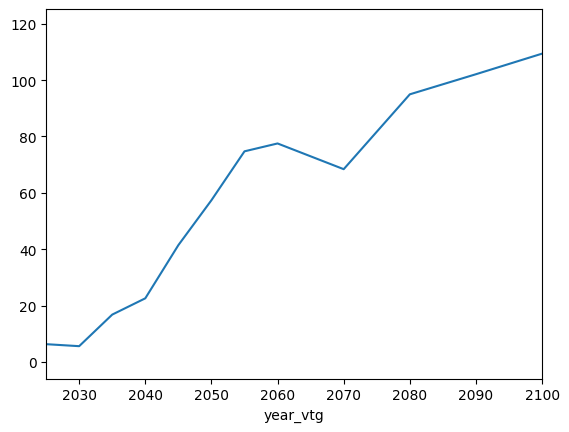

In [120]:
fig, ax = plt.subplots()
scenario.var('CAP_NEW')[scenario.var('CAP_NEW')['technology'] == 'ELC_100'].groupby(['technology', 'year_vtg']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('NEW_BEVS.jpg')

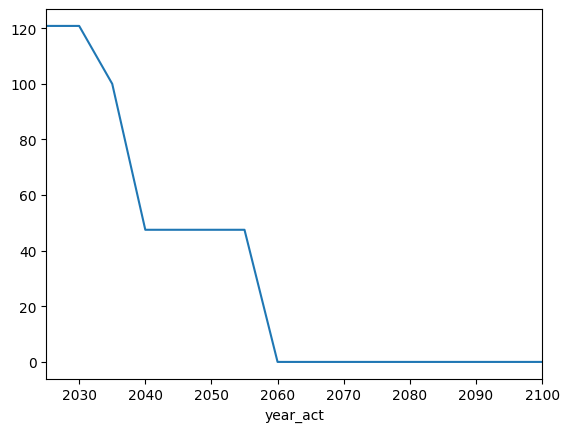

In [121]:
fig, ax = plt.subplots()
scenario.var('ACT')[scenario.var('ACT')['technology']=='NMC811_LIBmanufacturing'].groupby(['technology', 'year_act']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('ACT_NMC811.jpg')

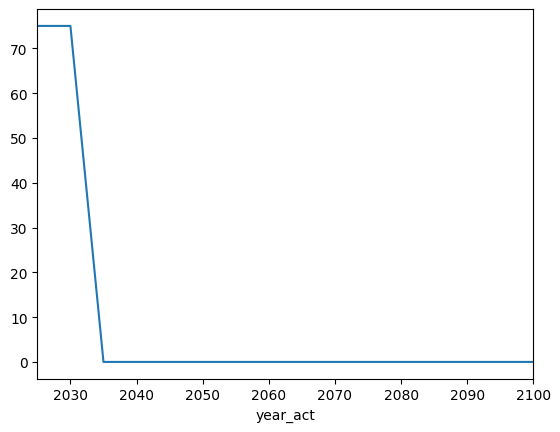

In [122]:
fig, ax = plt.subplots()
scenario.var('ACT')[scenario.var('ACT')['technology']=='NMC622_LIBmanufacturing'].groupby(['technology', 'year_act']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('ACT_NMC622.jpg')

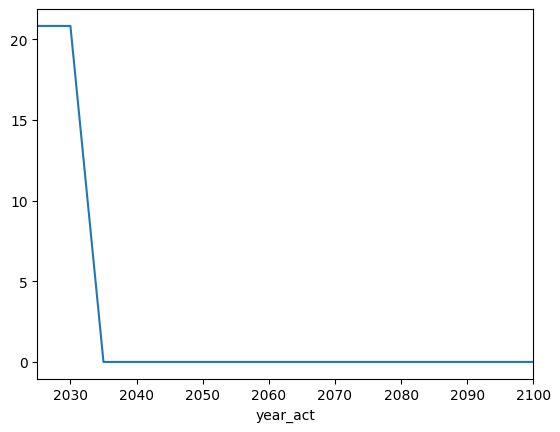

In [123]:
fig, ax = plt.subplots()
scenario.var('ACT')[scenario.var('ACT')['technology']=='NCA_LIBmanufacturing'].groupby(['technology', 'year_act']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('ACT_NCA.jpg')

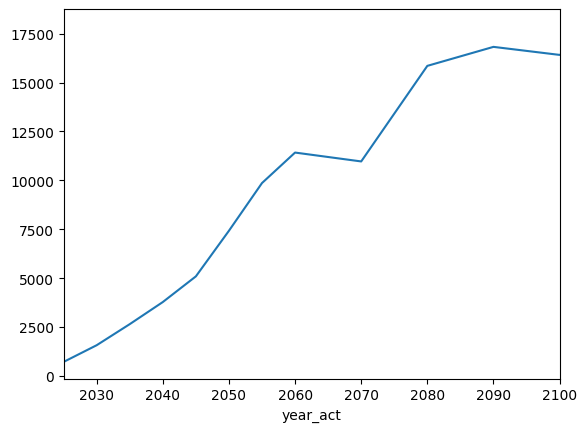

In [124]:
fig, ax = plt.subplots()
scenario.var('ACT')[scenario.var('ACT')['technology']=='LFP_LIBmanufacturing'].groupby(['technology', 'year_act']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('ACT_LFP.jpg')

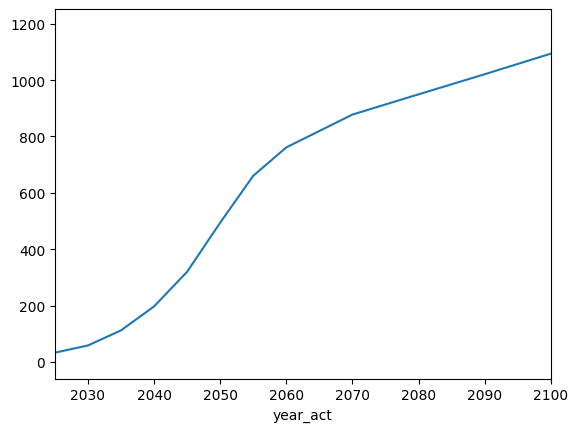

In [125]:
fig, ax = plt.subplots()
scenario.var('CAP')[scenario.var('CAP')['technology'] == 'ELC_100'].groupby(['technology', 'year_act']).sum()['lvl'].swaplevel(0,1).sort_index(axis=0,level=0).unstack().sum(axis = 1).plot()
ax.set_xlim(2025,2100)
plt.savefig('CAP_ELC100.jpg')

In [102]:
rep = Reporter.from_scenario(scenario)
configure(units={'replace': {'-': ''}})
df = rep.get('message::default')

# To dump the reporting data to an excel file if not already done
# This is not directly saved as xlsx, one should go to the generated file and save again. 

name = mod + "_" + comments + "_message_ix.xlsx"
df.to_excel(name)

var_cost: mixed units ['USD/GWa', '-', 'GUSD_2010 / Gv / km', 'Gv * km', 't', '???'] discarded
fix_cost: mixed units ['USD/GWa', 'USD/kWa', 'USD_2010 / v', 'GUSD_2010 / Gv / km', 't', '???', '-'] discarded
inv_cost: mixed units ['USD/GWa', 'USD/kWa', 'USD_2010 / v', 'GUSD_2010 / Gv / km', 't', 'USD/kW', '???', '-'] discarded
emission_factor: mixed units ['tC', '???', 'kg/kWa', 'kt / Gv / km', 't', '-'] discarded
input: mixed units ['GWa', '???', 'Gv km', 'GWa / Gv / km', 'GW * a / Gv / km', 'km', '-', 't', 'Mt', 'GWh', 'GWh/Mvehicle'] discarded
output: mixed units ['GWa', '-', 'Gt km', 'Gp km / a', 'Gv km', 'km', 'Gv * km', 'Gp km', 't', '???', 'Mt', 'GWh'] discarded


<Axes: title={'center': 'model: MaterialsTransport_Global - scenario: resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y - variable: CAP|capacity|PHEV_ptrp'}, xlabel='Year', ylabel='Value'>

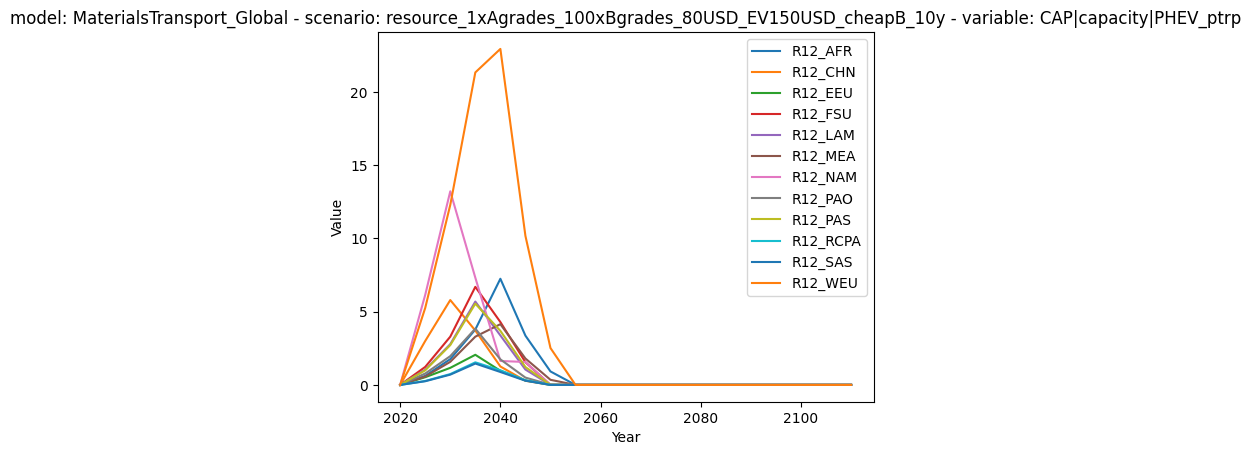

In [103]:
df.filter(variable = 'CAP|capacity|PHEV_ptrp', region = regions).plot()

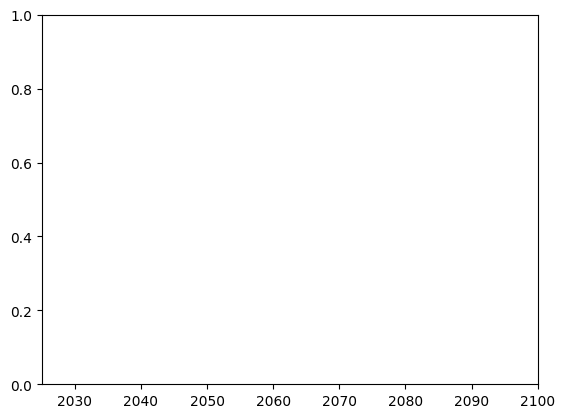

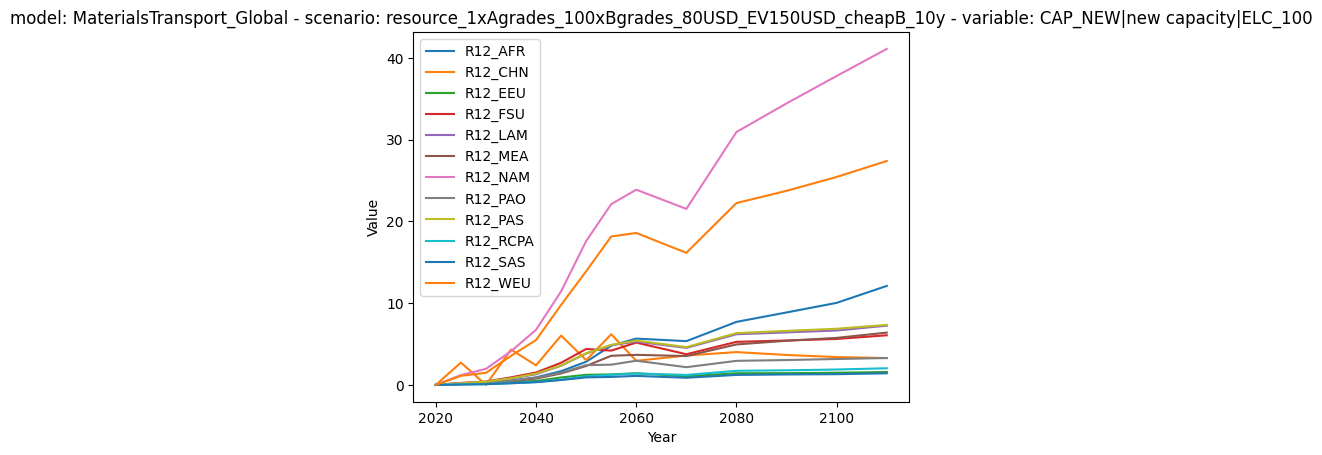

In [126]:
df.filter(variable = 'CAP_NEW|new capacity|ELC_100', region = regions).plot()

<Axes: title={'center': 'model: MaterialsTransport_Global - scenario: resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y - variable: CAP|capacity|ELC_100'}, xlabel='Year', ylabel='Value'>

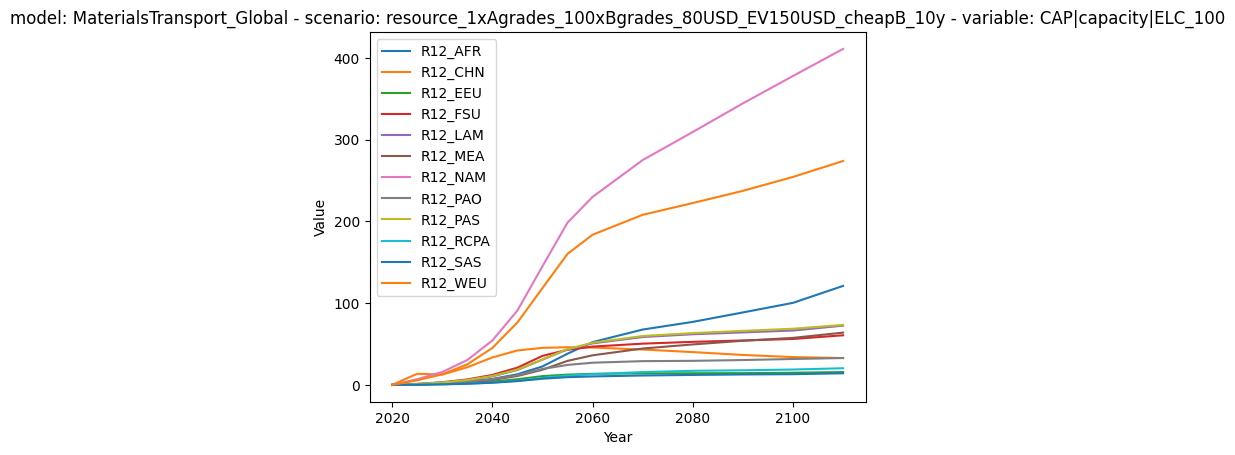

In [106]:
df.filter(variable = 'CAP|capacity|ELC_100', region = regions).plot()

<Axes: title={'center': 'model: MaterialsTransport_Global - scenario: resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y - variable: CAP|capacity|ICE_conv'}, xlabel='Year', ylabel='Value'>

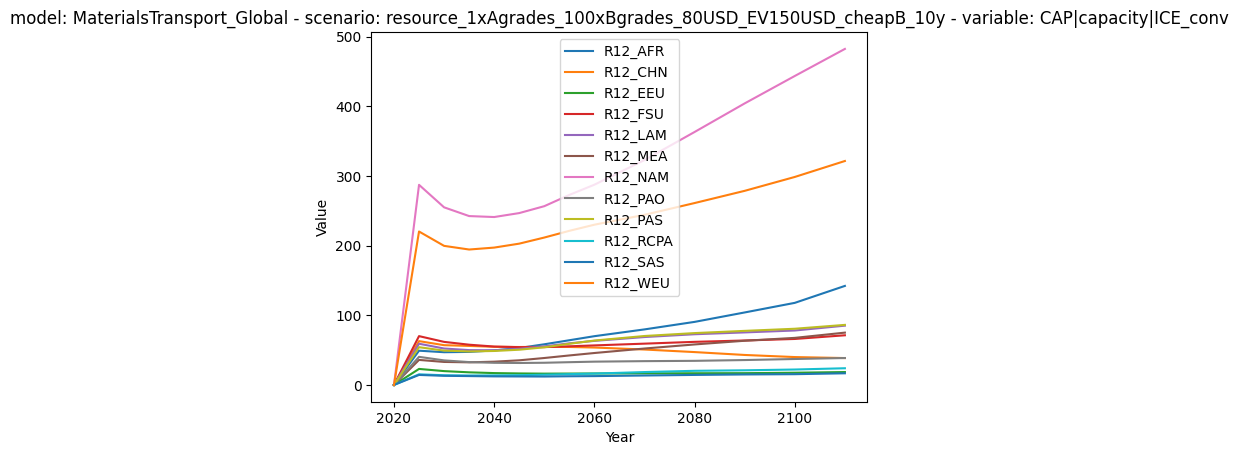

In [107]:
df.filter(variable = 'CAP|capacity|ICE_conv', region = regions).plot()

<Axes: title={'center': 'model: MaterialsTransport_Global - scenario: resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y - variable: CAP|capacity|HFC_ptrp'}, xlabel='Year', ylabel='Value'>

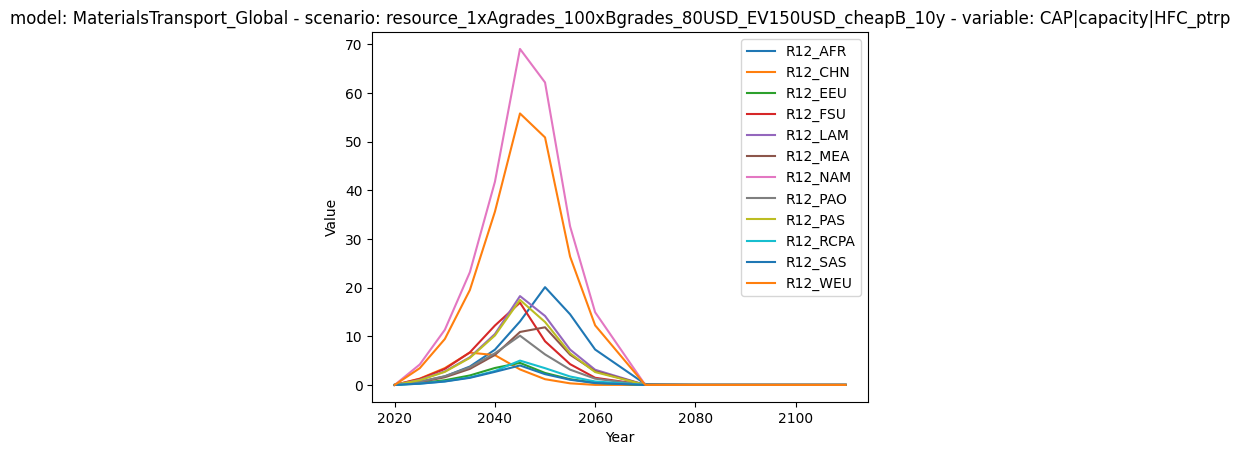

In [108]:
df.filter(variable = 'CAP|capacity|HFC_ptrp', region = regions).plot()

In [109]:
LIBs = [
    'CAP|capacity|NMC811_LIBmanufacturing',
    'CAP|capacity|NMC622_LIBmanufacturing',
    'CAP|capacity|NCA_LIBmanufacturing',
    'CAP|capacity|LFP_LIBmanufacturing'
    ]

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'model: MaterialsTransport_Global - scenario: resource_1xAgrades_100xBgrades_80USD_EV150USD_cheapB_10y'}, xlabel='Year', ylabel='Value'>

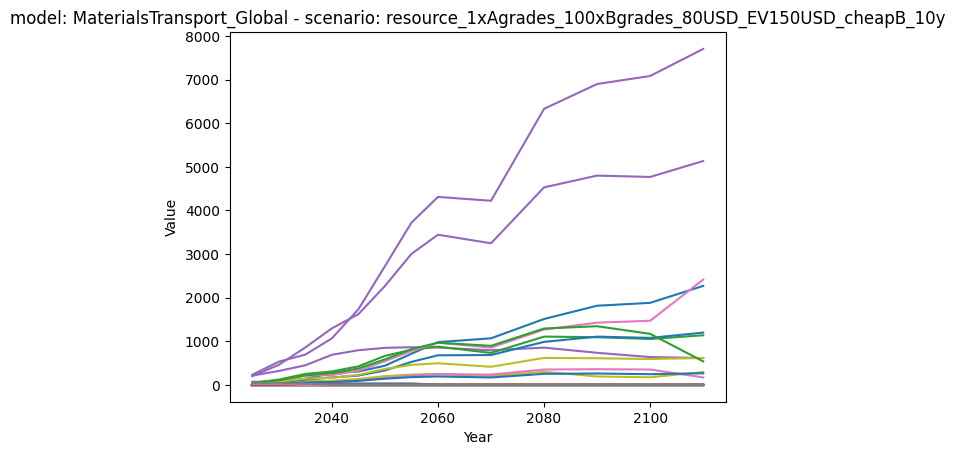

In [110]:
df.filter(variable = LIBs, region = regions).plot()

In [111]:

importlib.reload(message_data.tools.post_processing.iamc_report_hackathon)
message_data.tools.post_processing.iamc_report_hackathon.report(
    mp,
    scenario,
    # NB(PNK) this is not an error; .iamc_report_hackathon.report() expects a
    #         string containing "True" or "False" instead of an actual bool.
    "False",
    scenario.model,
    scenario.scenario,#.replace("_test_calib_macro", ""),
    merge_hist=False,#merge_hist=True,
    merge_ts=True,
    run_config="materials_run_config.yaml",
)

processing Table: Resource|Extraction
processing Table: Resource|Cumulative Extraction
processing Table: Primary Energy
processing Table: Primary Energy (substitution method)
processing Table: Final Energy
processing Table: Secondary Energy|Electricity
processing Table: Secondary Energy|Heat
processing Table: Secondary Energy
processing Table: Secondary Energy|Gases
processing Table: Secondary Energy|Solids
processing Table: Emissions|CO2
processing Table: Carbon Sequestration
processing Table: Emissions|BC
processing Table: Emissions|OC
processing Table: Emissions|CO
processing Table: Emissions|N2O
processing Table: Emissions|CH4
processing Table: Emissions|NH3
processing Table: Emissions|Sulfur
processing Table: Emissions|NOx
processing Table: Emissions|VOC
processing Table: Emissions|HFC
processing Table: Emissions
processing Table: Emissions
processing Table: Agricultural Demand
processing Table: Agricultural Production
processing Table: Fertilizer Use
processing Table: Food Waste
